# App to find Cheap Flights

# Introduction:

In 2014, the cheapest fare from New York to Vienna was found to be around $800, but according to the advertised fares, where for a select no. of dates, these tickets were between $350 and $450. 

It all seemed to be a good deal and one might wonder if whether it is true or not. The industry does mistake the occasional mistakes on fares, because airlines occasionally and accidentally do happen to post fares that exclude fuel surcharges. Normally, it is expected that the advanced algorithms employed by these airlines would be updating fares that takes into account large number of factors, however due to the order generations of systems in place, mistakes do happen.



# 1 Import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from time import sleep

# 2 - Retrieving the Data from scraping the web:

Fare data are obtained from a AJAX-based (Asynchornous JavaScript) webpage, this will require a browser to do the work. For such a task, there will be a need for two of the following pacakges: Selenium and ChromeDriver.

- Selenium is a package for automating web browsers.
- ChromeDriver is a headless browser, meaning there isn't a user interface.

In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver

chromeDriver_file = 'chromedriver'
chromeDriver_file_conda = 'chromedriver-binary alias'

import os
path = os.path.abspath(chromeDriver_file)
print('pathway to ChromeDriver is: ' + '\n' + path)

# Set the ChromeDriver pathway:
chromeDriver_path = path

browser = webdriver.Chrome(chromeDriver_path)

pathway to ChromeDriver is: 
/Users/y.s.lee/OneDrive/Packt - Python Machine Learning Blue Prints/Project 2 - App to find Cheap Flights/chromedriver


### 2.1 Set the URL (from google flights):

Dates are set to 1st of June to 15th of June in the year 2020 (note: that these dates can be changed to anything).

NOTE: Need to use the Freebase IDs for city/region of interest for travel. for example, m/06y57 is for Sydney. m/0f04v is for empty search. m/02_286 is for NYC.

It is possible to find it when searching in google from th ebelow link:
https://www.google.com.mx/travel/guide?q=New+York+City&sa=X&rlz=1C1CHBD_esMX769MX769&output=search&tra=%5B%22AMAbHIJDZRALeKKuHEbLXHGOJ3aS9zzCTg:1579328461567%22,%22syndey%22,%22/m/02_286%22%5D&tcfs=EhUKCS9tLzAyXzI4NhIITmV3IFlvcms&dest_mid=/m/06y57#dest_mid=/m/06y57&tcfs=EiwKCC9tLzA2eTU3EgZTeWRuZXkaGAoKMjAyMC0wMi0wMxIKMjAyMC0wMi0wNw

And to confirm it with the link below: make sure to control+f and search for Freebase ID.
https://www.wikidata.org/wiki/Q3130

In [3]:
# # Input webpage as string:
# flight_web_sats = 'https://www.google.com/travel/explore?tfs=CBsQAxojagcIARIDU1lEEgoyMDIwLTA2LTAxcgwIBBIIL20vMDJqOXoaI2oMCAQSCC9tLzAyajl6EgoyMDIwLTA2LTE1cgcIARIDU1lEcAFAAUgB&curr=AUD&gl=au&hl=en&authuser=0&origin=https%3A%2F%2Fwww.google.com&dest_mid'

# # Retrieve the webpage's content using Selenium:
# browser.get(flight_web_sats)

# # Check the title of the webpage:
# browser.title

In [4]:
# # Check to see if the required information from the webpage was captured: Take a Screenshot and save as 'test_flights.png'.
# current_work_directory = os.getcwd()
# sleep(30)
# browser.save_screenshot(current_work_directory + '/test_flights.png')

### 2.2 Parsing the DOM to extract the individual flight data from the HTML tags:

Document Object Model (DOM) is the collection of the individual elements on a webpage. These will include things like HTML tags, like 'body' and 'div', or classes and IDs.

In [5]:
# # Parsing:
# soup = BeautifulSoup(browser.page_source, "html.parser")

#### Extract the individual city data:

In [6]:
# # Get the city data:
# # At the time of HTML scraping, the flight data was inside <div class='MeBuN'>
# # Or the by XPATH: //*[@id="flt-app"]/c-wiz/c-wiz/nav/div[1]/nav/div/div[2]/ol/li[1]/div

# sleep(10)

# flight_cards = soup.select('div[class*=MebuN]')

# # Check out a single flight card:
# flight_cards[0]


From the piece of HTML information above, it can be noticed that the information needed is within the markup. 
For example: 
- the destination is seen here 'class="W6bZuc YMlIz" London',
- where the duration of the flight is 'class="Xq1DAb" 1 day 3 hr 20 min' 
- and prices are located at 'class="QB2Jof xLPuCe" datags="CidHQ2lQekJHLS0tLS0tLS0tcGZiMTI5QUFBQUFGNGlrY29Bby1aQUESATAaCwj+wAQQAhoDVVNE">$739'.

#### Next, is to obtain the required data from the markup:


In [7]:
# # For-loop to extract the relevant information:
# # At the time of HTML scraping, the price information are stored in <div class='MJg7fb'>

# # for card in flight_cards:
# #     print(card.select('h3')[0].text)
# #     print(card.select('div[class*=MJg7fb]')[0].text)
# #     print('\n')

# # Perform clean up of 'Great value' tags before the prices:
# for card in flight_cards:
#     print(card.select('h3')[0].text)
#     print(card.select('div[class*=MJg7fb]')[0].text.replace('Great value',""))
#     print('\n')

# browser.quit()

# print('Testing Complete.')

From the above, it can be confirmed that it is possible to retrieve the relevant data from the HTML. 

#### Next, is to retrieve flights that presents with the lowest cost and non-stop fares from the starting destination to the arrival destination. These flights would be for a 26 week period. All this is done by making a full scrape and parsing of a large number of fares.

#### Import the required libraries:

In [8]:
import datetime
from datetime import date, timedelta
from time import sleep

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

In [9]:
# Checks dict:
'''
Func: check if the structure is empty or not.
'''
def is_empty(any_structure):
    if any_structure:
#         print('Structure is not empty.')
        return False
    else:
#         print('Structure is empty.')
        return True

In [10]:
#======= Restart ChromeDriver =========
path = os.path.abspath(chromeDriver_file)
print('pathway to ChromeDriver is: ' + '\n' + path)
print('\n')

# Set the ChromeDriver pathway:
chromeDriver_path = path

browser = webdriver.Chrome(chromeDriver_path)

#======= Scraping the Web Data =========

week_period = 26
start_date = '2020-06-01'
end_date = '2020-06-15'
# start_date = '2020-04-01'
# end_date = '2020-04-15'
Adjust_delay = 50 # Adjust for internet connection. Default = 50
check_time = 7 # 7 days is teh default.\

check_wrong_startDate = datetime.datetime.strptime(start_date, '%Y-%m-%d')
check_wrong_date = check_wrong_startDate - timedelta(days = check_time)
check_wrong_date = str(check_wrong_date.date())

departure_destination = "Sydney"
arrival_destination = "Europe"

# Format the flight dates: with the python datetime standard.
startFlight_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
endFlight_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

# Dictionary for Fares:
flightFare_dict = {}

for idx in range(week_period):
    sat_start = str(startFlight_date).split()[0]
    sat_end = str(endFlight_date).split()[0]
    flightFare_dict.update({sat_start: {}})
    
    # Load webpage:
    sats = "https://www.google.com/flights?hl=en#flt=.." + sat_start + "*.." + sat_end + ";c:AUD;e:1;sd:1;t:h"
    sleep(np.random.randint(3,7))
    browser.get(sats)
    print('Index: ' + str(idx) + ' Starting Browser and searching link: Google ' + browser.title + '. Dates are: ' + sat_start + ' and ' + sat_end + '.' )
    
    # Input information to search for flights:
    wait_10sec = WebDriverWait(browser, 10) # Seconds of Waiting.

    print('Link Loaded, Entering Travel Details now.')

    # Departure Search: input of departure location.
    departureDestination_link = wait_10sec.until(EC.presence_of_element_located((By.XPATH, '//*[@id="flt-app"]/div[2]/main[1]/div[4]/div/div[3]/div/div[2]/div[1]')))
    departureDestination_link.click()
    departureDestination_link = wait_10sec.until(EC.presence_of_element_located((By.XPATH, '//*[@id="sb_ifc50"]/input')))
    sleep(1)
    departureDestination_link.send_keys(departure_destination)
    sleep(2)
    departureDestination_link.send_keys(Keys.ENTER)

    # Arrival Search: input of arrival location.
    arrivalDestination = wait_10sec.until(EC.presence_of_element_located((By.XPATH, '//*[@id="flt-app"]/div[2]/main[1]/div[4]/div/div[3]/div/div[2]/div[2]')))
    arrivalDestination.click()
    arrivalDestination = wait_10sec.until(EC.presence_of_element_located((By.XPATH, '//*[@id="sb_ifc50"]/input')))
    sleep(1)
    arrivalDestination.send_keys(arrival_destination)
    sleep(2)
    arrivalDestination.send_keys(Keys.ENTER)

    # Get new URL:
    sleep(1)
    new_browser_url = browser.current_url
    print('After inputting the destinations and searching, the new URL is: \n' + new_browser_url)

    # Finally, click on the 'Search' button:
    floatingActionButton_click = browser.find_elements_by_xpath('//*[@id="flt-app"]/div[2]/main[1]/div[4]/div/div[3]/div/div[4]/floating-action-button')[0]
    sleep(2)
    floatingActionButton_click.click()
    print('Search done. Next is to get a list of the travel information.')
    
    
    # Extract Relevant Data from webpage:
    print('Collecting data. \n')
    sleep(Adjust_delay)
    soup = BeautifulSoup(browser.page_source, 'html.parser')
    flight_cards = soup.select('div[class*=MebuN]')
    
    previous_sat_start_date = 0
    
    for card in flight_cards:
        print('Extracting...')
        while True:
            try:
                city = card.select('h3')[0].text
                fare = card.select('div[class*=MJg7fb]')[0].text.replace('Great value',"")    
                print(city)
                print(fare)
                print('\n')
                flightFare_dict[sat_start] = {**flightFare_dict[sat_start], **{city: fare}}
                   
            except RuntimeError as detail:
                print('Handling run-time error: ' + detail)
                continue
            break  


#     # Checks if the DICT in this current loop is empty, if YES, redo the data extraction:
#     previous_sat_start_date = startFlight_date - timedelta(days = check_time)
#     previous_sat_start_date = str(previous_sat_start_date.date())
    
#     if ( previous_sat_start_date == sat_start ):
#         continue   
    
#     elif ( previous_sat_start_date == check_wrong_date):
#         continue
    
#     elif ( is_empty(flightFare_dict[previous_sat_start_date]) ):
#         print('This current index loop DICT was found to be empty, Retrying to collect Data.')
#         sleep(1)
#         for card in flight_cards:
#             print('Alternate try of extracting...')
#             city = card.select('h3')[0].text
#             fare = card.select('div[class*=MJg7fb]')[0].text.replace('Great value',"")    
#             print(city)
#             print(fare)
#             print('\n')
#             flightFare_dict[sat_start] = {**flightFare_dict[sat_start], **{city: fare}}
#     else:
#         print('Error in collecting information, RETRY has FAILED.')
#         break
    
    
    # Update the date: Add 7 days.
    startFlight_date = startFlight_date + timedelta(days = check_time)
    endFlight_date = endFlight_date + timedelta(days = check_time)
#     print('\n')
    
browser.quit()
print('Quiting Broswer, Data Collection Complete.')

pathway to ChromeDriver is: 
/Users/y.s.lee/OneDrive/Packt - Python Machine Learning Blue Prints/Project 2 - App to find Cheap Flights/chromedriver


Index: 0 Starting Browser and searching link: Google Flights. Dates are: 2020-06-01 and 2020-06-15.
Link Loaded, Entering Travel Details now.
After inputting the destinations and searching, the new URL is: 
https://www.google.com/flights?hl=en#flt=..2020-06-01*..2020-06-15;c:AUD;e:1;sd:1;t:h
Search done. Next is to get a list of the travel information.

Extracting...
London
A$1,074


Extracting...
Paris
A$1,134


Extracting...
Rome
A$901


Extracting...
Amsterdam
A$907


Extracting...
Athens
A$1,236


Extracting...
Dublin
A$1,272


Extracting...
Manchester
A$1,295


Extracting...
Frankfurt
A$1,001


Extracting...
İstanbul
A$1,241


Extracting...
Stockholm
A$1,420


Extracting...
Barcelona
A$1,094


Extracting...
Milan
A$1,250


Extracting...
Berlin
A$926


Extracting...
Madrid
A$1,248


Extracting...
Zürich
A$1,259


Extracting...
Munich


In [11]:
# is_empty(flightFare_dict[previous_sat_start_date]) 

In [12]:
# startFlight_date

In [13]:
flightFare_dict

{'2020-06-01': {'London': 'A$1,074',
  'Paris': 'A$1,134',
  'Rome': 'A$901',
  'Amsterdam': 'A$907',
  'Athens': 'A$1,236',
  'Dublin': 'A$1,272',
  'Manchester': 'A$1,295',
  'Frankfurt': 'A$1,001',
  'İstanbul': 'A$1,241',
  'Stockholm': 'A$1,420',
  'Barcelona': 'A$1,094',
  'Milan': 'A$1,250',
  'Berlin': 'A$926',
  'Madrid': 'A$1,248',
  'Zürich': 'A$1,259',
  'Munich': 'A$1,396',
  'Copenhagen': 'A$1,158',
  'Reykjavík': 'A$1,884',
  'Vienna': 'A$1,353',
  'Edinburgh': 'A$1,311',
  'Moscow': 'A$1,279',
  'Malta': 'A$1,356',
  'Helsinki': 'A$1,530',
  'Venice': 'A$1,561',
  'Budapest': 'A$1,401',
  'Geneva': 'A$1,392',
  'Lisbon': 'A$1,307',
  'Belgrade': 'A$1,453',
  'Brussels': 'A$1,300',
  'Prague': 'A$1,389',
  'Skopje': 'A$1,408',
  'Oslo': 'A$1,486',
  'Warsaw': 'A$1,458',
  'Glasgow': 'A$1,341',
  'Birmingham': 'A$1,471',
  'Nice': 'A$1,636',
  'Zagreb': 'A$1,421',
  'Düsseldorf': 'A$1,501',
  'Hamburg': 'A$1,475',
  'Newcastle upon Tyne': 'A$1,347'},
 '2020-06-08': {'Lond

In [14]:
# flight_cards = soup.select('div[class*=MebuN]')
# flight_cards

## 2.3 Check out the data collected from the 26 week period:

Begin with checking out flights heading to Berlin.

In [15]:
# Checking out outward flights to Berlin:

city_key = 'Berlin'
for key in flightFare_dict:
    print(key, flightFare_dict[key][city_key])

2020-06-01 A$926
2020-06-08 A$966
2020-06-15 A$1,001
2020-06-22 A$1,086
2020-06-29 A$1,131
2020-07-06 A$1,333
2020-07-13 A$1,086
2020-07-20 A$1,086
2020-07-27 A$1,041
2020-08-03 A$1,086
2020-08-10 A$1,046
2020-08-17 A$936
2020-08-24 A$936
2020-08-31 A$891
2020-09-07 A$1,046
2020-09-14 A$1,254
2020-09-21 A$966
2020-09-28 A$966
2020-10-05 A$896
2020-10-12 A$1,316
2020-10-19 A$1,226
2020-10-26 A$1,226
2020-11-02 A$1,231
2020-11-09 A$1,231
2020-11-16 A$1,231
2020-11-23 A$1,276


It can be seen that there will be some need of further cleaning of the data, such as removing the 'A$'for AUD dollars from the price data and to remove the ',' commas.

In [16]:
city_dict = {}

for k, v in flightFare_dict.items():
    city_dict.update({k: int(v[city_key].replace(',','').split('$')[1])})

In [17]:
city_dict

{'2020-06-01': 926,
 '2020-06-08': 966,
 '2020-06-15': 1001,
 '2020-06-22': 1086,
 '2020-06-29': 1131,
 '2020-07-06': 1333,
 '2020-07-13': 1086,
 '2020-07-20': 1086,
 '2020-07-27': 1041,
 '2020-08-03': 1086,
 '2020-08-10': 1046,
 '2020-08-17': 936,
 '2020-08-24': 936,
 '2020-08-31': 891,
 '2020-09-07': 1046,
 '2020-09-14': 1254,
 '2020-09-21': 966,
 '2020-09-28': 966,
 '2020-10-05': 896,
 '2020-10-12': 1316,
 '2020-10-19': 1226,
 '2020-10-26': 1226,
 '2020-11-02': 1231,
 '2020-11-09': 1231,
 '2020-11-16': 1231,
 '2020-11-23': 1276}

After some cleaning, it can be seen that the values appears as wanted. 

#### Plot the data:

[Text(0, 0, '2020-06-01'),
 Text(0, 0, '2020-06-08'),
 Text(0, 0, '2020-06-15'),
 Text(0, 0, '2020-06-22'),
 Text(0, 0, '2020-06-29'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-13'),
 Text(0, 0, '2020-07-20'),
 Text(0, 0, '2020-07-27'),
 Text(0, 0, '2020-08-03'),
 Text(0, 0, '2020-08-10'),
 Text(0, 0, '2020-08-17'),
 Text(0, 0, '2020-08-24'),
 Text(0, 0, '2020-08-31'),
 Text(0, 0, '2020-09-07'),
 Text(0, 0, '2020-09-14'),
 Text(0, 0, '2020-09-21'),
 Text(0, 0, '2020-09-28'),
 Text(0, 0, '2020-10-05'),
 Text(0, 0, '2020-10-12'),
 Text(0, 0, '2020-10-19'),
 Text(0, 0, '2020-10-26'),
 Text(0, 0, '2020-11-02'),
 Text(0, 0, '2020-11-09'),
 Text(0, 0, '2020-11-16'),
 Text(0, 0, '2020-11-23')]

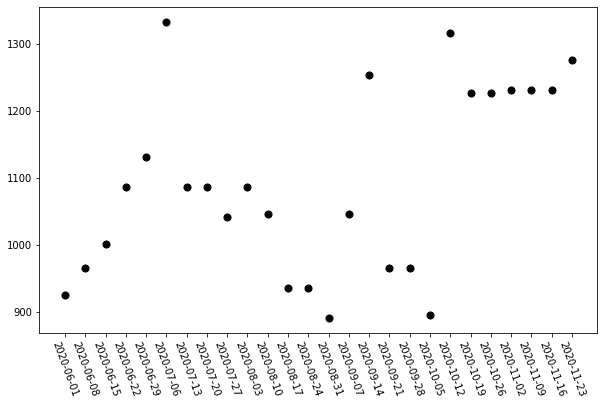

In [18]:
# Convert prices to integers:
prices = [int(x) for x in city_dict.values()]

# Extract the Date data from the dictionary:
dates = city_dict.keys()

# Plot:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(x = dates,
            y = prices,
            color = 'black',
            s = 50           
           )
ax.set_xticklabels(dates, rotation = -70)

From the plot above, where they are flights from Sydney to Berlin, shows 26 consecutive weeks of data and have some variations to these fares. These can range from 900 AUD dollars to 1350 AUD dollars. It can also be said that initially from just eyeballing it, there isn't a certain pattern to these fares.

#### Now, having a look at another City: Milan.

In [74]:
# Checking out outward flights to Milan:

city_key = 'Milan'
for key in flightFare_dict:
    print(key, flightFare_dict[key][city_key])

2020-06-01 A$1,250
2020-06-08 A$1,250
2020-06-15 A$1,250
2020-06-22 A$1,826
2020-06-29 A$2,233
2020-07-06 A$2,017
2020-07-13 A$1,670
2020-07-20 A$1,606
2020-07-27 A$1,426
2020-08-03 A$1,250
2020-08-10 A$1,377
2020-08-17 A$1,426
2020-08-24 A$1,426
2020-08-31 A$1,425
2020-09-07 A$1,426
2020-09-14 A$1,300
2020-09-21 A$1,529
2020-09-28 A$1,362
2020-10-05 A$1,174
2020-10-12 A$1,174
2020-10-19 A$1,133
2020-10-26 A$1,128
2020-11-02 A$1,133
2020-11-09 A$1,128
2020-11-16 A$1,128
2020-11-23 A$1,174


In [75]:
city_dict = {}

for k, v in flightFare_dict.items():
    city_dict.update({k: int(v[city_key].replace(',','').split('$')[1])})

[Text(0, 0, '2020-06-01'),
 Text(0, 0, '2020-06-08'),
 Text(0, 0, '2020-06-15'),
 Text(0, 0, '2020-06-22'),
 Text(0, 0, '2020-06-29'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-13'),
 Text(0, 0, '2020-07-20'),
 Text(0, 0, '2020-07-27'),
 Text(0, 0, '2020-08-03'),
 Text(0, 0, '2020-08-10'),
 Text(0, 0, '2020-08-17'),
 Text(0, 0, '2020-08-24'),
 Text(0, 0, '2020-08-31'),
 Text(0, 0, '2020-09-07'),
 Text(0, 0, '2020-09-14'),
 Text(0, 0, '2020-09-21'),
 Text(0, 0, '2020-09-28'),
 Text(0, 0, '2020-10-05'),
 Text(0, 0, '2020-10-12'),
 Text(0, 0, '2020-10-19'),
 Text(0, 0, '2020-10-26'),
 Text(0, 0, '2020-11-02'),
 Text(0, 0, '2020-11-09'),
 Text(0, 0, '2020-11-16'),
 Text(0, 0, '2020-11-23')]

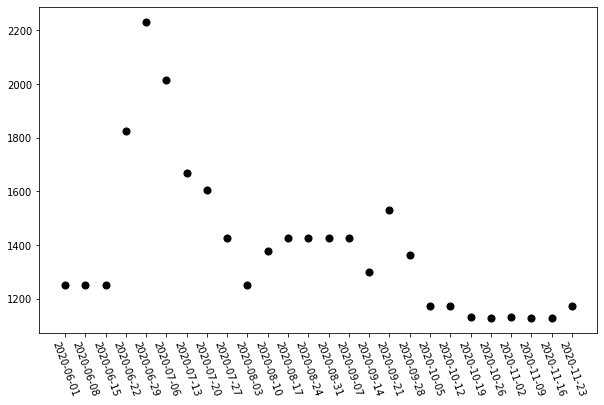

In [76]:
# Convert prices to integers:
prices = [int(x) for x in city_dict.values()]

# Extract the Date data from the dictionary:
dates = city_dict.keys()

# Plot:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(x = dates,
            y = prices,
            color = 'black',
            s = 50           
           )
ax.set_xticklabels(dates, rotation = -70)

From the plot above, where they are flights from Sydney to Milan and the fares ranges from 1150 AUD dollars to 2250 AUD dollars. The types of cheap fares of interests can be seen from the dates of 26th Oct to 16th of Nov (around 1150 AUD dollars). These are the Outliers of interest.

#### Next is to create an outlier detection system to notify the user of such cheap fares

# 3 Outlier Detection System: for cheap flights:

Outliers can be describe as an observation that lies outside the overall pattern of a distribution. (ref: http://mathworld.wolfram.com/Outlier.html)
Such outliers can be determined by techniques that are both parametric and non-parametric. Once of the techniques utilised is the density-based spatial clustering of application with noise (DBSCAN). Another is called Grubb's Test. Depending on the type of data that present itself, where it can be multivariate or univariate, the technique utilised is different.

For the purpose of this notebook, the data is a univariate time-series data, and that the technique to be used is called the Generalised Extreme Studentised Deviate (GESD) test specifically for outliers. (ref: http://www.real-statistics.com/students-t-distribution/identifying-outliers-using-t-distribution/generalized-extreme-studentized-deviate-test/)


## 3.1 Import the required Libraries:

In [77]:
from scipy import stats

#### Plot the data with probability plot:

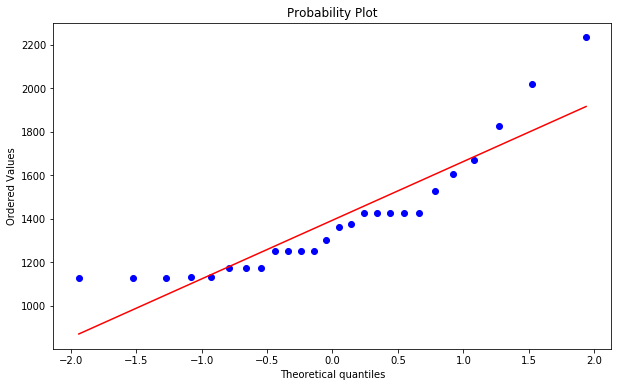

In [78]:
fix, ax = plt.subplots(figsize = (10, 6))
stats.probplot(list(city_dict.values()), plot = plt)
plt.show()

From the plot above, . This assesses the normal probability (or the Q-Q plot, quantile-quantile). The diagonal straight line in the plot is the 'normal' line, and that any data close to this straight line is considered normal and not an outlier. The outliers are data points that veers off away from the straight line, or presents with a strong S-shape. 

In the case where there are more data available, it is more likely that the pattern/trend will be approximate to the diagonal straight line.

## 3.2 Outlier detection code:

#### Import the required library:

In [79]:
from PyAstronomy import pyasl

City -> Milan
Total Outliers:  1
Outlier Dates dict_keys(['2020-06-29']) 

        R         Lambda
 1  3.02081  2.98566
 2  2.90996  2.96529
 3  2.66224  2.94376


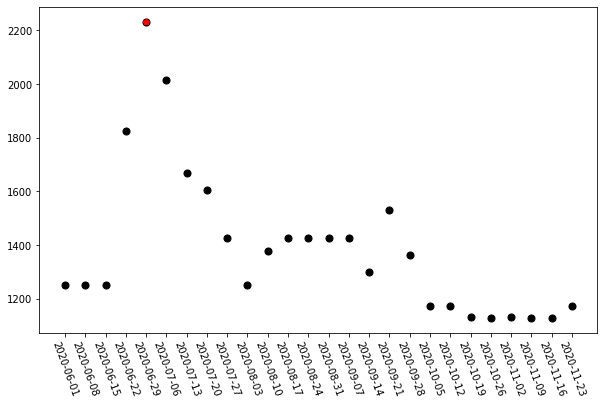

In [80]:
fare_prices = prices
max_outliers = 3
significance_lvl = 0.025 #lower value means less sensitive to false positives in the algorithm

r = pyasl.generalizedESD(fare_prices, max_outliers, significance_lvl, fullOutput = True)
print('City -> ' + city_key)
print('Total Outliers: ', r[0])

# Print out data in regards to 'R' and Lambda: used to determine if data point is an outlier.
out_dates = {}
for i in sorted(r[1]):
    out_dates.update({list(dates)[i]: list(prices)[i]})   
print('Outlier Dates', out_dates.keys(), '\n')
print('        R         Lambda')

# Make plot: outliers are in red colour.
for i in range(len(r[2])):
    print('%2d %8.5f %8.5f' % ((i+1), r[2][i], r[3][i]))
    
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(dates, prices, color = 'black', s=50)
ax.set_xticklabels(dates, rotation =-70);

for i in range(r[0]):
    plt.plot(r[1][i], prices[r[1][i]], 'rp')
    

From the above, 1 outliers were found. However, it can be seen that this outlier (at 29-06-2020) has a fare price of above $2200, but is not below the average price. For now this is okay because it means the model is picking out the outliers from the data.

## 3.3 Now, having a look at another City: Moscow.

[Text(0, 0, '2020-06-01'),
 Text(0, 0, '2020-06-08'),
 Text(0, 0, '2020-06-15'),
 Text(0, 0, '2020-06-22'),
 Text(0, 0, '2020-06-29'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-13'),
 Text(0, 0, '2020-07-20'),
 Text(0, 0, '2020-07-27'),
 Text(0, 0, '2020-08-03'),
 Text(0, 0, '2020-08-10'),
 Text(0, 0, '2020-08-17'),
 Text(0, 0, '2020-08-24'),
 Text(0, 0, '2020-08-31'),
 Text(0, 0, '2020-09-07'),
 Text(0, 0, '2020-09-14'),
 Text(0, 0, '2020-09-21'),
 Text(0, 0, '2020-09-28'),
 Text(0, 0, '2020-10-05'),
 Text(0, 0, '2020-10-12'),
 Text(0, 0, '2020-10-19'),
 Text(0, 0, '2020-10-26'),
 Text(0, 0, '2020-11-02'),
 Text(0, 0, '2020-11-09'),
 Text(0, 0, '2020-11-16'),
 Text(0, 0, '2020-11-23')]

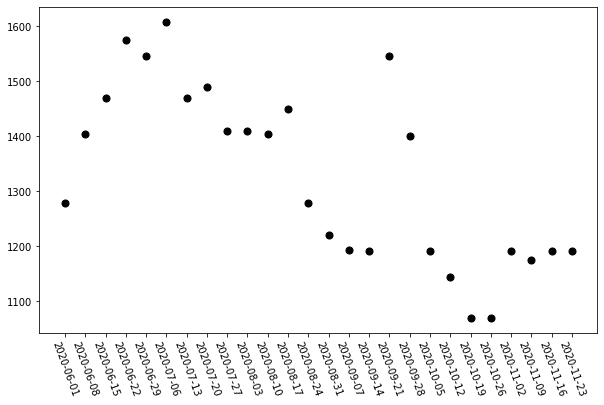

In [93]:
# Checking out outward flights to Moscow:
city_key = 'Moscow'
  
# Update the Dictionary:
city_dict = {}

for k, v in flightFare_dict.items():
    city_dict.update({k: int(v[city_key].replace(',','').split('$')[1])})
    

# Plot the data:
# Convert prices to integers:
prices = [int(x) for x in city_dict.values()]

# Extract the Date data from the dictionary:
dates = city_dict.keys()

# Plot:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(x = dates,
            y = prices,
            color = 'black',
            s = 50           
           )
ax.set_xticklabels(dates, rotation = -70)

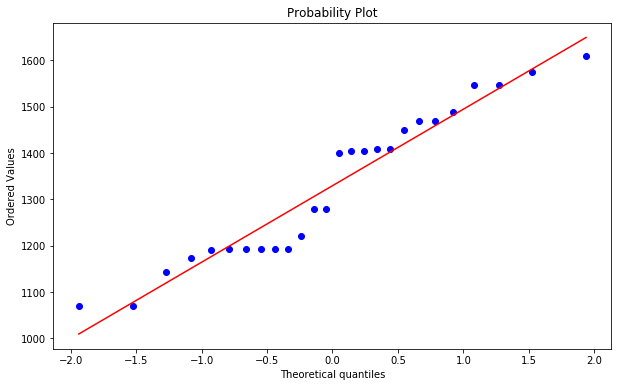

In [82]:
# Plot the probability plot
fix, ax = plt.subplots(figsize = (10, 6))
stats.probplot(list(city_dict.values()), plot = plt)
plt.show()

City -> Moscow
Total Outliers:  0
Outlier Dates dict_keys([]) 

        R         Lambda
 1  1.74787  2.98566
 2  1.68653  2.96529
 3  1.62960  2.94376


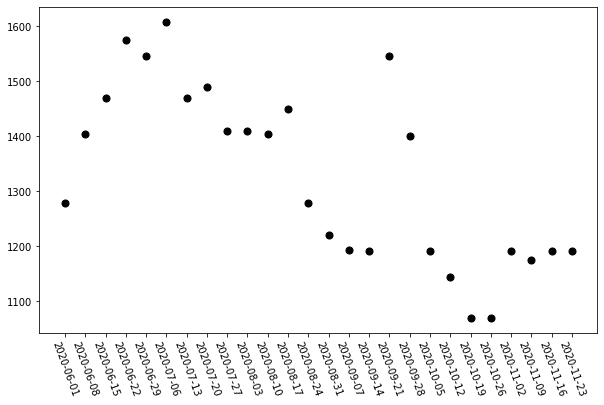

In [83]:
# Outlier Detection:
fare_prices = prices
max_outliers = 3
significance_lvl = 0.025 #lower value means less sensitive to false positives in the algorithm

r = pyasl.generalizedESD(fare_prices, max_outliers, significance_lvl, fullOutput = True)
print('City -> ' + city_key)
print('Total Outliers: ', r[0])

# Print out data in regards to 'R' and Lambda: used to determine if data point is an outlier.
out_dates = {}
for i in sorted(r[1]):
    out_dates.update({list(dates)[i]: list(prices)[i]})   
print('Outlier Dates', out_dates.keys(), '\n')
print('        R         Lambda')

# Make plot: outliers are in red colour.
for i in range(len(r[2])):
    print('%2d %8.5f %8.5f' % ((i+1), r[2][i], r[3][i]))
    
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(dates, prices, color = 'black', s=50)
ax.set_xticklabels(dates, rotation =-70);

for i in range(r[0]):
    plt.plot(r[1][i], prices[r[1][i]], 'rp')
    

For Moscow:


## 3.4 Now, having a look at another City: Athens.

[Text(0, 0, '2020-06-01'),
 Text(0, 0, '2020-06-08'),
 Text(0, 0, '2020-06-15'),
 Text(0, 0, '2020-06-22'),
 Text(0, 0, '2020-06-29'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-13'),
 Text(0, 0, '2020-07-20'),
 Text(0, 0, '2020-07-27'),
 Text(0, 0, '2020-08-03'),
 Text(0, 0, '2020-08-10'),
 Text(0, 0, '2020-08-17'),
 Text(0, 0, '2020-08-24'),
 Text(0, 0, '2020-08-31'),
 Text(0, 0, '2020-09-07'),
 Text(0, 0, '2020-09-14'),
 Text(0, 0, '2020-09-21'),
 Text(0, 0, '2020-09-28'),
 Text(0, 0, '2020-10-05'),
 Text(0, 0, '2020-10-12'),
 Text(0, 0, '2020-10-19'),
 Text(0, 0, '2020-10-26'),
 Text(0, 0, '2020-11-02'),
 Text(0, 0, '2020-11-09'),
 Text(0, 0, '2020-11-16'),
 Text(0, 0, '2020-11-23')]

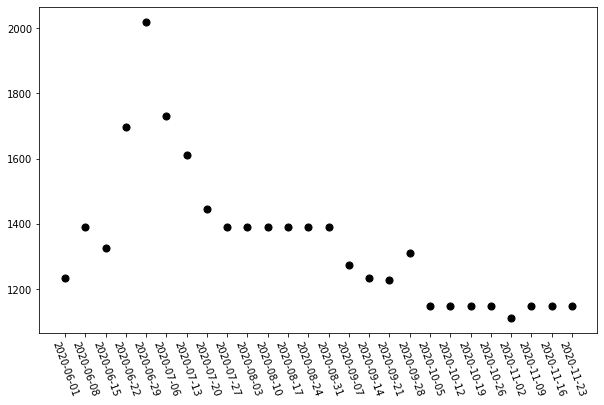

In [94]:
# Checking out outward flights to Athens:
city_key = 'Athens'

# Update the Dictionary:
city_dict = {}

for k, v in flightFare_dict.items():
    city_dict.update({k: int(v[city_key].replace(',','').split('$')[1])})
    

# Plot the data:
# Convert prices to integers:
prices = [int(x) for x in city_dict.values()]

# Extract the Date data from the dictionary:
dates = city_dict.keys()

# Plot:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(x = dates,
            y = prices,
            color = 'black',
            s = 50           
           )
ax.set_xticklabels(dates, rotation = -70)

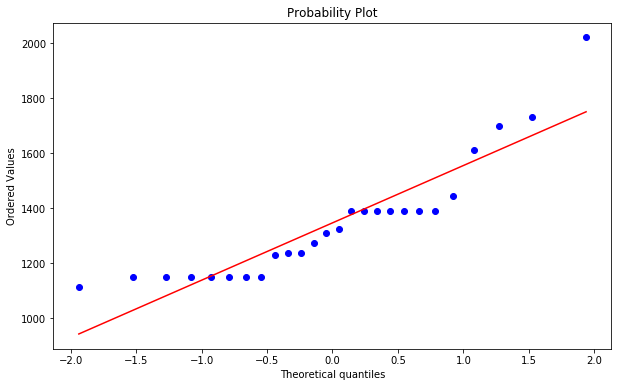

In [95]:
# Plot the probability plot
fix, ax = plt.subplots(figsize = (10, 6))
stats.probplot(list(city_dict.values()), plot = plt)
plt.show()

City -> Athens
Total Outliers:  1
Outlier Dates dict_keys(['2020-06-29']) 

        R         Lambda
 1  3.14887  2.98566
 2  2.42205  2.96529
 3  2.62429  2.94376


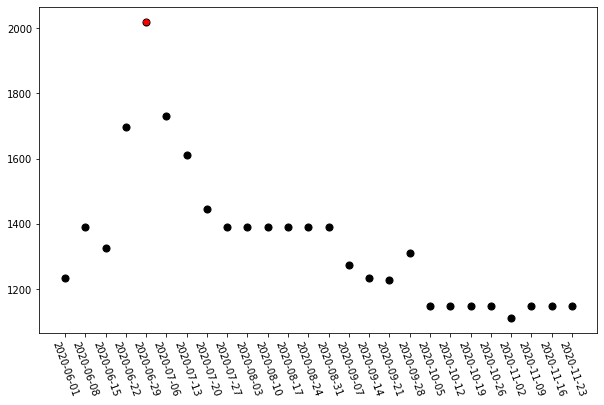

In [96]:
# Outlier Detection:
fare_prices = prices
max_outliers = 3
significance_lvl = 0.025 #lower value means less sensitive to false positives in the algorithm

r = pyasl.generalizedESD(fare_prices, max_outliers, significance_lvl, fullOutput = True)
print('City -> ' + city_key)
print('Total Outliers: ', r[0])

# Print out data in regards to 'R' and Lambda: used to determine if data point is an outlier.
out_dates = {}
for i in sorted(r[1]):
    out_dates.update({list(dates)[i]: list(prices)[i]})   
print('Outlier Dates', out_dates.keys(), '\n')
print('        R         Lambda')

# Make plot: outliers are in red colour.
for i in range(len(r[2])):
    print('%2d %8.5f %8.5f' % ((i+1), r[2][i], r[3][i]))
    
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(dates, prices, color = 'black', s=50)
ax.set_xticklabels(dates, rotation =-70);

for i in range(r[0]):
    plt.plot(r[1][i], prices[r[1][i]], 'rp')
    

## 3.5 Now, having a look at another City: London.

[Text(0, 0, '2020-06-01'),
 Text(0, 0, '2020-06-08'),
 Text(0, 0, '2020-06-15'),
 Text(0, 0, '2020-06-22'),
 Text(0, 0, '2020-06-29'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-13'),
 Text(0, 0, '2020-07-20'),
 Text(0, 0, '2020-07-27'),
 Text(0, 0, '2020-08-03'),
 Text(0, 0, '2020-08-10'),
 Text(0, 0, '2020-08-17'),
 Text(0, 0, '2020-08-24'),
 Text(0, 0, '2020-08-31'),
 Text(0, 0, '2020-09-07'),
 Text(0, 0, '2020-09-14'),
 Text(0, 0, '2020-09-21'),
 Text(0, 0, '2020-09-28'),
 Text(0, 0, '2020-10-05'),
 Text(0, 0, '2020-10-12'),
 Text(0, 0, '2020-10-19'),
 Text(0, 0, '2020-10-26'),
 Text(0, 0, '2020-11-02'),
 Text(0, 0, '2020-11-09'),
 Text(0, 0, '2020-11-16'),
 Text(0, 0, '2020-11-23')]

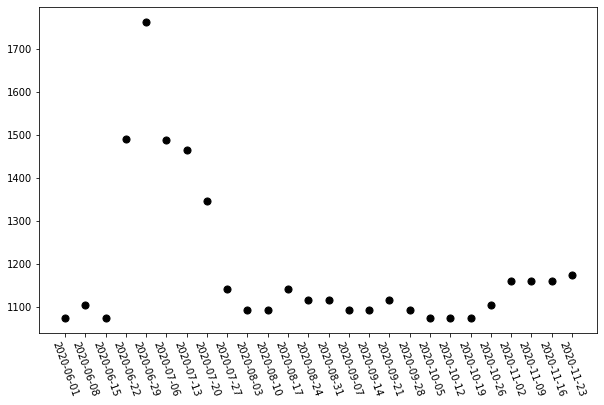

In [97]:
# Checking out outward flights to London:
city_key = 'London'

# Update the Dictionary:
city_dict = {}

for k, v in flightFare_dict.items():
    city_dict.update({k: int(v[city_key].replace(',','').split('$')[1])})
    

# Plot the data:
# Convert prices to integers:
prices = [int(x) for x in city_dict.values()]

# Extract the Date data from the dictionary:
dates = city_dict.keys()

# Plot:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(x = dates,
            y = prices,
            color = 'black',
            s = 50           
           )
ax.set_xticklabels(dates, rotation = -70)

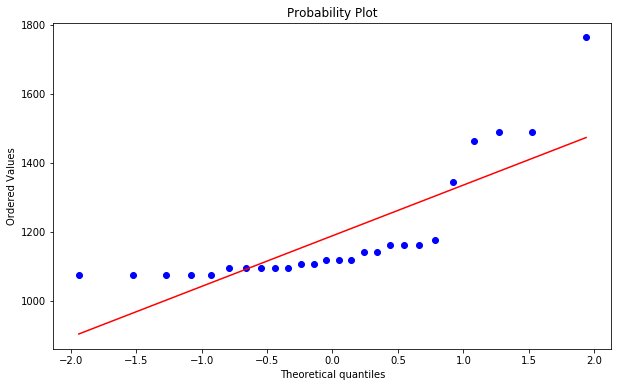

In [98]:
# Plot the probability plot
fix, ax = plt.subplots(figsize = (10, 6))
stats.probplot(list(city_dict.values()), plot = plt)
plt.show()

City -> London
Total Outliers:  3
Outlier Dates dict_keys(['2020-06-22', '2020-06-29', '2020-07-06']) 

        R         Lambda
 1  3.36708  2.98566
 2  2.52466  2.96529
 3  2.98897  2.94376


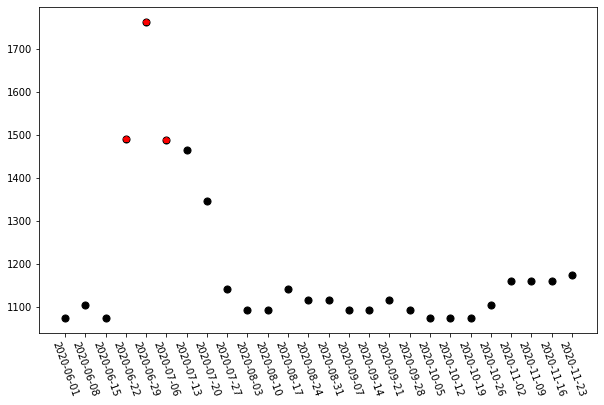

In [99]:
# Outlier Detection:
fare_prices = prices
max_outliers = 3
significance_lvl = 0.025 #lower value means less sensitive to false positives in the algorithm

r = pyasl.generalizedESD(fare_prices, max_outliers, significance_lvl, fullOutput = True)
print('City -> ' + city_key)
print('Total Outliers: ', r[0])

# Print out data in regards to 'R' and Lambda: used to determine if data point is an outlier.
out_dates = {}
for i in sorted(r[1]):
    out_dates.update({list(dates)[i]: list(prices)[i]})   
print('Outlier Dates', out_dates.keys(), '\n')
print('        R         Lambda')

# Make plot: outliers are in red colour.
for i in range(len(r[2])):
    print('%2d %8.5f %8.5f' % ((i+1), r[2][i], r[3][i]))
    
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(dates, prices, color = 'black', s=50)
ax.set_xticklabels(dates, rotation =-70);

for i in range(r[0]):
    plt.plot(r[1][i], prices[r[1][i]], 'rp')
    

From the above,

## 3.6 Now, having a look at another City: Edinburgh.

[Text(0, 0, '2020-06-01'),
 Text(0, 0, '2020-06-08'),
 Text(0, 0, '2020-06-15'),
 Text(0, 0, '2020-06-22'),
 Text(0, 0, '2020-06-29'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-13'),
 Text(0, 0, '2020-07-20'),
 Text(0, 0, '2020-07-27'),
 Text(0, 0, '2020-08-03'),
 Text(0, 0, '2020-08-10'),
 Text(0, 0, '2020-08-17'),
 Text(0, 0, '2020-08-24'),
 Text(0, 0, '2020-08-31'),
 Text(0, 0, '2020-09-07'),
 Text(0, 0, '2020-09-14'),
 Text(0, 0, '2020-09-21'),
 Text(0, 0, '2020-09-28'),
 Text(0, 0, '2020-10-05'),
 Text(0, 0, '2020-10-12'),
 Text(0, 0, '2020-10-19'),
 Text(0, 0, '2020-10-26'),
 Text(0, 0, '2020-11-02'),
 Text(0, 0, '2020-11-09'),
 Text(0, 0, '2020-11-16'),
 Text(0, 0, '2020-11-23')]

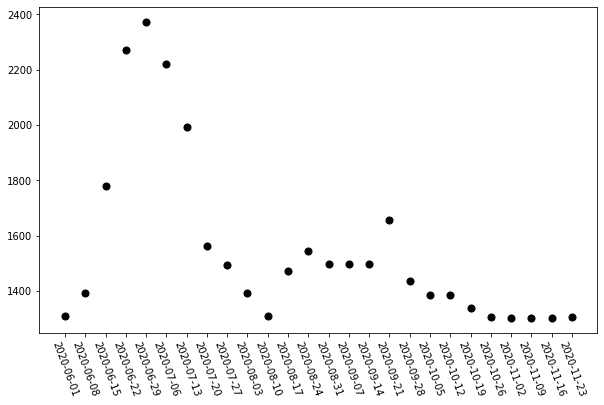

In [100]:
# Checking out outward flights to Edinburgh:
city_key = 'Edinburgh'

# Update the Dictionary:
city_dict = {}

for k, v in flightFare_dict.items():
    city_dict.update({k: int(v[city_key].replace(',','').split('$')[1])})
    

# Plot the data:
# Convert prices to integers:
prices = [int(x) for x in city_dict.values()]

# Extract the Date data from the dictionary:
dates = city_dict.keys()

# Plot:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(x = dates,
            y = prices,
            color = 'black',
            s = 50           
           )
ax.set_xticklabels(dates, rotation = -70)

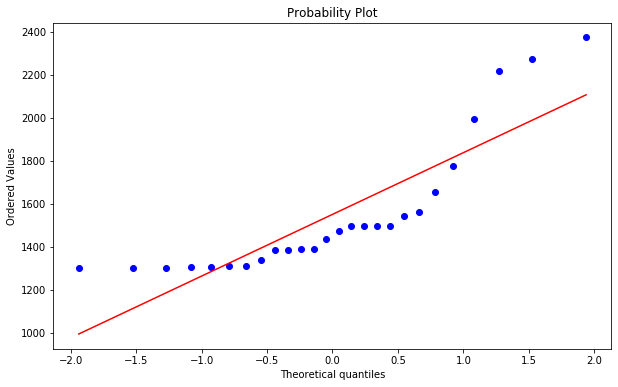

In [101]:
# Plot the probability plot
fix, ax = plt.subplots(figsize = (10, 6))
stats.probplot(list(city_dict.values()), plot = plt)
plt.show()

City -> Edinburgh
Total Outliers:  3
Outlier Dates dict_keys(['2020-06-22', '2020-06-29', '2020-07-06']) 

        R         Lambda
 1  2.65035  2.98566
 2  2.80768  2.96529
 3  3.26535  2.94376


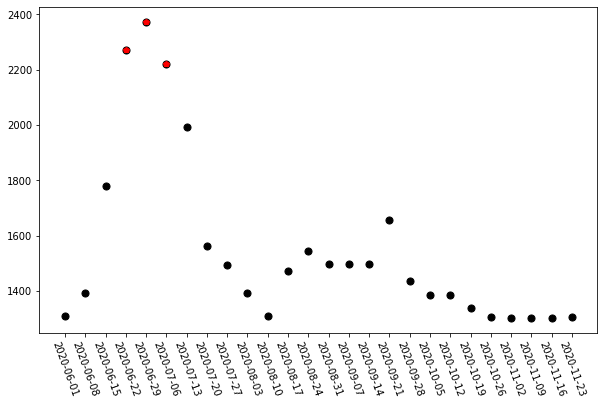

In [102]:
# Outlier Detection:
fare_prices = prices
max_outliers = 3
significance_lvl = 0.025 #lower value means less sensitive to false positives in the algorithm

r = pyasl.generalizedESD(fare_prices, max_outliers, significance_lvl, fullOutput = True)
print('City -> ' + city_key)
print('Total Outliers: ', r[0])

# Print out data in regards to 'R' and Lambda: used to determine if data point is an outlier.
out_dates = {}
for i in sorted(r[1]):
    out_dates.update({list(dates)[i]: list(prices)[i]})   
print('Outlier Dates', out_dates.keys(), '\n')
print('        R         Lambda')

# Make plot: outliers are in red colour.
for i in range(len(r[2])):
    print('%2d %8.5f %8.5f' % ((i+1), r[2][i], r[3][i]))
    
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(dates, prices, color = 'black', s=50)
ax.set_xticklabels(dates, rotation =-70);

for i in range(r[0]):
    plt.plot(r[1][i], prices[r[1][i]], 'rp')
    

From the above,